# User Experience Concept for Specutils fitting 

Created May 2018

This is an example user workflow showing the plan for a typical line-fitting operation for a user.

Note: this is *not* scoped to be "all line fitting for everyone".  Plenty of astronomers have strong opinions about various parts of this process and probably want to do their own thing.  The goal here is to provide pieces that users can use to produce their own workflows in that case.

##  Preliminaries

This illustrates how one might get the data - the first case demonstrates a hypothetical spectrum from NIRSpec/etc from JWST.  The second is a more generic "I'm loading my data from a file" case.

In [ ]:
import specutils

In [ ]:
# if you have jwst data

import jwsttools #NEEDS IMPLEMENTING

program_data = jwsttools.download_program(pid=1234)
spectral_collection = program_data.spectra
spectra = spectral_collection.as_list()  

Note re: the above: `SpectralCollection` doesn't yet exit... it might be it can be treated as a list in the end. But the point is that `spectra` should act like a list of `Spectrum1D` objects in the end to match the below cell.

In [ ]:
# if you are from some random telescope that gave you any of the formats specutils can read
from glob import glob

fns = glob('my_awesome_spectra_*.fits')
spectra = [specutils.Spectrum1D.read(fn) for fn in fns]

## One spectrum vs many

In most cases the user will be thinking about one spectrum.  They might do on as an example, and then apply the algorithms repeatedly (that's the case considered at the end of this notebook).  Others may wish to repeat these steps individually or in part for *every* spectrum in their dataset. In principal, `SpectrumCollection` will enable at least some of these steps.  For the sake of clarity, though (and simplicity in initial implementation), here we consider the "one spectrum" case, on the theory that the rest is either a for-loop or many copy-and-pasted cells.

In [ ]:
spectrum = spectra[0]  # spectrum is now a specutils.Spectrum1D object

## Viewing the spectrum

Some sort of view of the spectrum is critical. Below we consider the "easy" and "fancy" versions: the rest of the notebook will mostly assume the former, but the idea is that some/all of the steps that require interaction could be automated in the "fancy" version.

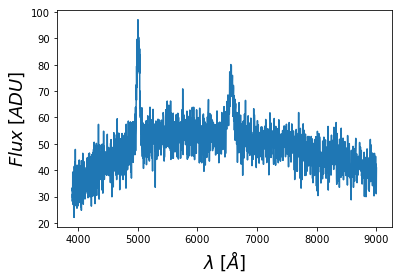

In [52]:
import specviz


# This *might* belong in specutils, possibly even spectrum.plot() although that requires some discussion/decision
specviz.plot_spectrum(spectrum)  

OR

In [1]:
specviz.show(spectrum)

A FANCY NOTEBOOK-BASED SPECVIZ GUI GOES HERE!


The GUI above could include most of the Qt specviz features, but in this view would be limited to interactive viewing/rescaling, and selection of ROIs.  The assumption is that everything else the user is doing is in the notebook.

## Step "0": continuum fitting

Some spectra come out of the pipeline continuum-subtracted, or the continuum might be so low that it's effectively missing.  In those cases this step isn't necessary. 

In other cases, they come out-of-the-pipeline flux calibrated. In that case, for some science cases the user has their own continuum model that they construct and subtract from the spectrum (not addressed here, but allowing this step to be skipped).

In yet other cases users want their model to *include* the continuum in some manner or another, leading to skipping the second part of this step.

The end result is a spectrum that has been either:

1. Unaltered 
2. Continuum-subtracted
3. Continuum-normalized

The steps below should accept all these cases, although not necessarily equally well.

## Step 1: Identify Lines

## Step 2: Guesses

## Step 3: Fit Lines

## Step n: Wash, Rinse, and Repeat

# Miscellaneous stuff (not part of the interface document)

Below here is code to "fake" the plots above, etc.  Not a part of the actual document.

In [14]:
import numpy as np

from astropy import units as u
from astropy.modeling import models
from astropy.modeling.blackbody import FLAM

%matplotlib inline
from matplotlib import pyplot as plt

In [25]:
models.Gaussian1D(0.01,6563, 5)(31)

0.0

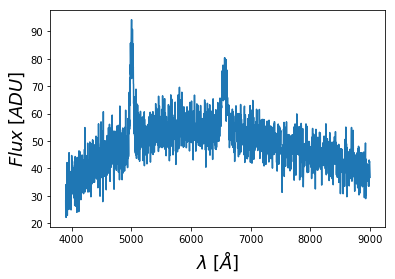

In [53]:
fake_spectrum_x = np.logspace(np.log10(3900), np.log10(9000), 2048)*u.angstrom
fake_spectrum = 500000*models.BlackBody1D(temperature=4800*u.K)(fake_spectrum_x).to(FLAM, u.spectral_density(fake_spectrum_x)).value
fake_spectrum += models.Gaussian1D(20,6563, 45)(fake_spectrum_x.value)
fake_spectrum += models.Gaussian1D(40,5007, 25)(fake_spectrum_x.value)
fake_spectrum += 5*np.random.randn(len(fake_spectrum_x))

plt.plot(fake_spectrum_x, fake_spectrum)
plt.xlabel('$\lambda \; [\AA]$', fontsize=18)
plt.ylabel('$Flux \; [ADU]$', fontsize=18)